In [1]:
import glob
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

def create_model(base_model, classData):
    for layer in base_model.layers:
        layer.trainable = False
    top_model = base_model.output 
    #flatten layer
    top_model = Flatten(name="flatten")(top_model)
    #dense layer
    top_model = Dense(1024, activation='relu')(top_model)
    #dropout layer
    top_model = Dropout(0.2)(top_model)
    #dense layer
    output_layer = Dense(classData, activation='softmax')(top_model)
    model = Model(inputs=base_model.input, outputs=output_layer)
    
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])        
            
    return model


train_path = '../aug_oversampling_v2_dataset/balanced_oversampling'
test_path  = '../aug_oversampling_v2_dataset/test_data'
IMG_SHAPE = (224, 224, 3)
batch_size = 32
classData = 10

base_model = EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SHAPE,
)

model = create_model(base_model, classData)
# model.summary()

In [2]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="training",
    seed=123,
    label_mode='categorical',
    image_size=(224,224),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=batch_size
)

Found 10000 files belonging to 10 classes.
Using 9000 files for training.
Found 10000 files belonging to 10 classes.
Using 1000 files for validation.


In [3]:
#custom callback
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
282/282 [==============================] - 662s 2s/step - loss: 1.0776 - accuracy: 0.6689 - val_loss: 0.5492 - val_accuracy: 0.8410
Epoch 2/10
282/282 [==============================] - 630s 2s/step - loss: 0.3352 - accuracy: 0.8909 - val_loss: 0.4060 - val_accuracy: 0.8790
Epoch 3/10
282/282 [==============================] - 631s 2s/step - loss: 0.1657 - accuracy: 0.9487 - val_loss: 0.3849 - val_accuracy: 0.9040
Epoch 4/10
282/282 [==============================] - 630s 2s/step - loss: 0.1297 - accuracy: 0.9617 - val_loss: 0.4905 - val_accuracy: 0.8800
Epoch 5/10
282/282 [==============================] - 631s 2s/step - loss: 0.1132 - accuracy: 0.9657 - val_loss: 0.3976 - val_accuracy: 0.8990
Epoch 6/10
282/282 [==============================] - 633s 2s/step - loss: 0.0776 - accuracy: 0.9762 - val_loss: 0.4137 - val_accuracy: 0.8930


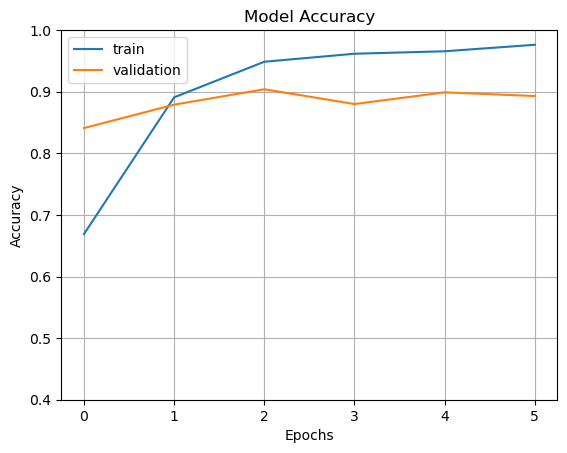

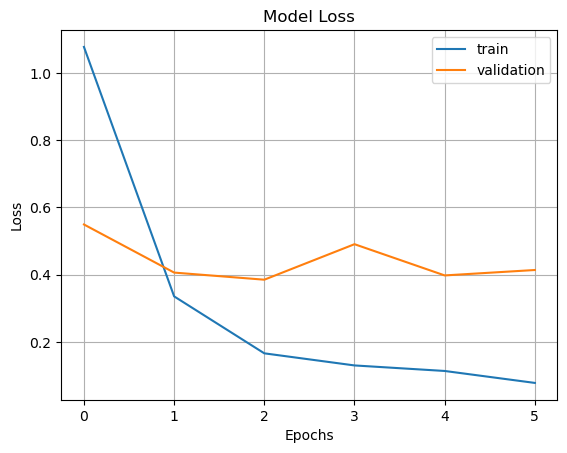

In [4]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
# axes[0].plot(x1, y1)
# axes[1].plot(x2, y2)

In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    shuffle=False,
    label_mode="categorical",
    image_size=(224,224),
    batch_size=1
)

predictions = model.predict(test_ds)

Found 1000 files belonging to 10 classes.
1000/1000 [==============================] - 136s 133ms/step


In [6]:
import numpy as np
from sklearn.metrics import classification_report

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

predicted_categories = np.argmax(predictions, axis=1)

true_categories = tf.concat([y for x, y in test_ds], axis=0).numpy()
true_categories_argmax = np.argmax(true_categories, axis=1)

print(classification_report(true_categories_argmax, predicted_categories, target_names=class_names, digits=4))

                          precision    recall  f1-score   support

   bacterial_leaf_blight     0.9213    0.8200    0.8677       100
   bacterial_leaf_streak     0.9583    0.9200    0.9388       100
bacterial_panicle_blight     0.9327    0.9700    0.9510       100
                   blast     0.8667    0.9100    0.8878       100
              brown_spot     0.8990    0.8900    0.8945       100
              dead_heart     0.9892    0.9200    0.9534       100
            downy_mildew     0.8725    0.8900    0.8812       100
                   hispa     0.9785    0.9100    0.9430       100
                  normal     0.9247    0.8600    0.8912       100
                  tungro     0.7857    0.9900    0.8761       100

                accuracy                         0.9080      1000
               macro avg     0.9129    0.9080    0.9085      1000
            weighted avg     0.9129    0.9080    0.9085      1000



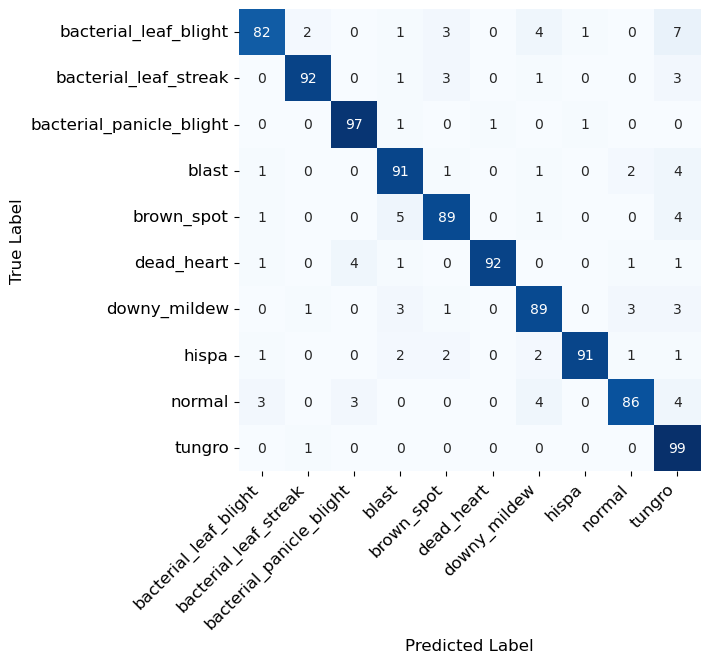

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

class_names = ["bacterial_leaf_blight","bacterial_leaf_streak","bacterial_panicle_blight","blast","brown_spot","dead_heart","downy_mildew","hispa","normal","tungro"]

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

plot_heatmap(true_categories_argmax, predicted_categories, class_names, ax, title="EfficientNetV2B0-UnderSampling")    

#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()

In [8]:
model.save('PaddyDisease_EfficientNetV2B0_OverSampling_224_v2.h5')